In [42]:
# Importing Libraries
import json
import random
random.seed(33) # for reproducibility

Suppose we have a directed graph of four 2-bit vertices, $\vec{G} = {V, \vec{E}}$ Where $V = {a, b, c, d}$ and $\vec{E} = {(\vec{ab},\vec{ac} ,\vec{bd}, \vec{cd})}$.
<div>
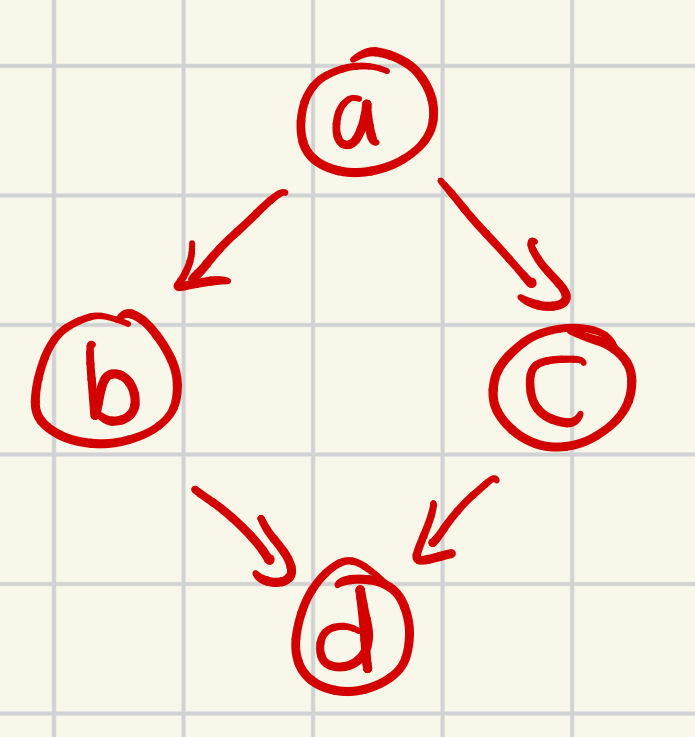
</div>

Additionally, each vertex can be in one of 2 states: +1 or -1 state. 


We are interested in the probability each vertex being in a any state, and we know the probability of a vertex being in any state given the states of its parent vertices:

$\mathbb{P}(+d | +b, +c) = 0.3$, 

$\mathbb{P}(+d | +b, -c) = 0.1$, 

$\mathbb{P}(+d | -b, +c) = 0.2$, 

$\mathbb{P}(+d | -b, -c) = 0.9$, 

$\mathbb{P}(+a) = 0.8$, 

$\mathbb{P}(+b | +a) = 0.8$, 

$\mathbb{P}(+b | -a) = 0.5$, 

$\mathbb{P}(+c | +a) = 0.7$, 

$\mathbb{P}(+c | -a) = 0.1$

With this information, we can use gibbs sampling to estimate the probabilities of each vertex being in each state.


In [ ]:
To begin this demo, we fill first open our files containing our data

In [51]:

# open adj list and local conditions
print("Opening n.json and adjList.json and localConditions.json.....")
try:
    with open('../data/gibbs_data/n.json', 'r') as file:
        n = json.load(file)
except FileNotFoundError:
    print("Error: 'n.json' not found.")
except json.JSONDecodeError:
    print("Error: Invalid JSON format in 'n.json'.")

    
try:
    with open('../data/gibbs_data/localConditionals.json', 'r') as file:
        data_dict = json.load(file)
    # print(data_dict)
    # print(data_dict["+d+b+c"])
except FileNotFoundError:
    print("Error: 'localConditionals.json' not found.")
except json.JSONDecodeError:
    print("Error: Invalid JSON format in 'localConditionals.json'.")


try:
    with open('../data/gibbs_data/adjList.json', 'r') as file:
        adj_dict = json.load(file)
except FileNotFoundError:
    print("Error: 'adjList.json' not found.")
except json.JSONDecodeError:
    print("Error: Invalid JSON format in 'adjList.json'.")
    # print(adj_dict)
    # print("children of 'a' is " + adj_dict["outgoing"]["a"])
    # print("parent of 'a' is " + adj_dict["incoming"]["a"])


Opening n.json and adjList.json and localConditions.json.....


In [ ]:
In one round of gibbs sampling, we do the following:

- Out of all the vertices, select one vertex $x$, to be resampled
  - For that vertex, observe the states of all other vertices and sample $x$ based on the matching conditional distribution.

- For example, if our vertices look like this currently: $+a, -b, +c, +d$, and we select c, we will find $\mathbb{P}(+c | +a)$ Since $c$ depend on $a$. The probability of c being in +1 state given the conditions is 0.7. Suppose our random number generateor sampled c to be negative. Then, we would update our vertices to be $+a, -b, -c, +d$ and pick the next vertex to be sampled. Once we sampled all vertices once in this manner, we have completed 1 round of gibbs sampling and we save these vertex states as an instance.

We do this for N number of times (We specify what N is). 

After we finish our sampling, for each vector $x$, we can estimate the probability of +1 state by finding all instances of +x in our saved instances, and divide that by number of trials to get the percent of +x for each vertex. 

And with only conditional distributions, we have successfully estimated the individual probabilities of each vertex. 

In [54]:

def gibbsRound(lst): 
    # print(lst)
    for i in range(len(lst)):         # one round
        pos = 1
        neg = 1
        pquery = ""
        nquery = ""
        temp = lst[i][-1]
        
        posList = list(lst)
        posList[i] = "+" + temp
        negList = list(lst)
        negList[i] = "-" + temp
        #print(posList)
        #print(negList)
        for j in range(len(lst)): # finding everyones parents
            #print(lst[j][-1], end = "")
            x = posList[j]
            y = negList[j]
            parents = adj_dict["incoming"][lst[j][-1]]
            #print("'s parents: ")
            for vtx in parents: # for each parent
                x += "".join(signedvtx for signedvtx in posList if vtx in signedvtx)
                y += "".join(signedvtx for signedvtx in negList if vtx in signedvtx)
            if x[0] == '-':
                x = '+' + x[1:]
                pos*=(1- data_dict[x])
            else: pos*=(data_dict[x])
            if y[0] == '-':
                y = '+' + y[1:]
                neg*=(1- data_dict[y])
            else: neg*=(data_dict[y])
            
        total = (pos)/(pos + neg) # we got prob of P(something | all others)
        #print (total)
        num = random.random()
        #print("our vtx of interest was ", lst[i], ". We calc prob of it is", total , "because rand gen was", num, "we changed list to")
        if (total > num):
            lst[i] = "+" + lst[i][-1]
        else:
            lst[i] = "-" + lst[i][-1]
    
    return lst

        # do thing on positive list
        # do thing on negative list
        # prob = pos / (pos + neg)


        
        
        # find p i| others = +i and others / +i and others + -i and others
        # for everything in there, look up in table and calculate probability
        # cal rand num gen between 0 and 1. if prob is < then positive else negative. Make change at that index. 
    
print("Success! Running gibbsSampling for n = ", n, " trials (you can change this)...")
def gibbsSampling(k):
    n = 0
    lst = []
    for i in adj_dict["outgoing"]:
        n+= 1
        temp = ""
        temp += random.choice(['+', '-']) + i
        lst.append(temp) # just to start off
        
    result = []
    for i in range(k):
        result.append(list(gibbsRound(lst)))
    return result
result = gibbsSampling(n)
print("Success! Found: ")
def unpack():
    for key in adj_dict["incoming"]:
        count = sum(1 for vecs in result if ('+'+key) in vecs)
        print ("P(+", key ,") is approx", count/n)

unpack()

Success! Running gibbsSampling for n =  340000  trials (you can change this)...
Success! Found: 
P(+ a ) is approx 0.7988029411764705
P(+ b ) is approx 0.7391911764705882
P(+ c ) is approx 0.5792794117647059
P(+ d ) is approx 0.3158970588235294


In [55]:
result

[['+a', '-b', '+c', '-d'],
 ['+a', '-b', '+c', '+d'],
 ['+a', '+b', '+c', '-d'],
 ['+a', '+b', '+c', '-d'],
 ['+a', '+b', '+c', '-d'],
 ['+a', '+b', '+c', '-d'],
 ['+a', '+b', '-c', '-d'],
 ['+a', '+b', '-c', '+d'],
 ['-a', '-b', '-c', '+d'],
 ['-a', '-b', '-c', '+d'],
 ['-a', '-b', '-c', '-d'],
 ['-a', '+b', '-c', '-d'],
 ['+a', '+b', '+c', '-d'],
 ['+a', '-b', '+c', '-d'],
 ['+a', '+b', '-c', '-d'],
 ['+a', '+b', '+c', '-d'],
 ['+a', '+b', '-c', '-d'],
 ['+a', '+b', '-c', '-d'],
 ['-a', '+b', '-c', '-d'],
 ['-a', '+b', '-c', '-d'],
 ['+a', '+b', '-c', '+d'],
 ['+a', '+b', '+c', '+d'],
 ['+a', '+b', '+c', '-d'],
 ['+a', '+b', '-c', '-d'],
 ['-a', '+b', '-c', '-d'],
 ['+a', '+b', '-c', '-d'],
 ['+a', '+b', '+c', '-d'],
 ['-a', '+b', '-c', '-d'],
 ['-a', '+b', '+c', '+d'],
 ['+a', '+b', '+c', '+d'],
 ['+a', '+b', '+c', '-d'],
 ['+a', '+b', '-c', '-d'],
 ['-a', '-b', '-c', '+d'],
 ['+a', '+b', '-c', '-d'],
 ['-a', '+b', '-c', '-d'],
 ['+a', '+b', '+c', '-d'],
 ['+a', '+b', '+c', '-d'],
 

In [34]:
# Number of Gibbs sampling interations
num_iterations = 20
samples = []